# The Exploration of Latents of MODIS L2 by Umap

In [1]:
### used to set the interpreter searching path
import sys
target_path = '/home/jovyan/ulmo/'
sys.path.append(target_path)

In [27]:
%matplotlib inline

from importlib import reload
import os
import numpy as np

import pandas

import h5py
import seaborn as sns
import pandas as pd
import umap

from ulmo.analysis import io as analy_io
from ulmo.utils import image_utils
from ulmo import plotting
from ulmo import io as ulmo_io
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
from tqdm import trange

In [3]:
reload(image_utils)

<module 'ulmo.utils.image_utils' from '/home/jovyan/ulmo/ulmo/utils/image_utils.py'>

In [4]:
### Load the table
evals_path = '/home/jovyan/modis_dataset/MODIS_L2_std.feather'
evals_tbl = ulmo_io.load_main_table(evals_path)

Read main table: /home/jovyan/modis_dataset/MODIS_L2_std.feather


In [5]:
### Check if there exist any 'NaN' values
print(evals_tbl.isna().sum())

lat                      0
lon                      0
col                      0
datetime                 0
LL                  135712
row                      0
clear_fraction           0
mean_temperature         0
Tmin                     0
Tmax                     0
T90                      0
T10                      0
filename                 0
UID                      0
pp_file                  0
pp_root                  0
field_size               0
pp_type                  0
pp_idx                   0
dtype: int64


In [6]:
### Quick try: drop the 'NaN' points
evals_tbl_drop = evals_tbl.dropna()
print(evals_tbl_drop.isna().sum())

lat                 0
lon                 0
col                 0
datetime            0
LL                  0
row                 0
clear_fraction      0
mean_temperature    0
Tmin                0
Tmax                0
T90                 0
T10                 0
filename            0
UID                 0
pp_file             0
pp_root             0
field_size          0
pp_type             0
pp_idx              0
dtype: int64


In [7]:
### Show the example
# field, mask = image_utils.grab_modis_l2_img(example, 'PreProc', ptype='std')

In [8]:
### Load the latents file
lat_file = '/home/jovyan/modis_dataset/' \
           'MODIS_R2019_2019_95clear_128x128_latents_std.h5'

l_h5 = h5py.File(lat_file, 'r')
latents = l_h5['latents']
latents.shape

(751689, 512)

In [9]:
### Show the statistics of several features of the latents
latents_part_df = pd.DataFrame(latents[:, :400])
latents_part_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 751689 entries, 0 to 751688
Columns: 400 entries, 0 to 399
dtypes: float32(400)
memory usage: 1.1 GB


In [10]:
latents_part_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
count,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,...,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000
mean,0.004975,0.001060,-0.001625,0.007018,0.010252,-0.004330,-0.001359,-0.000082,-0.005402,0.000272,...,0.004499,-0.007422,-0.002398,0.004064,0.010843,0.002954,0.004194,0.000145,-0.011412,-0.006052
std,0.973913,0.983361,0.973651,0.983246,0.985160,0.987386,0.978668,0.982144,0.981116,0.978854,...,0.976631,0.984997,0.980497,0.981389,0.973373,0.979601,0.992584,0.982193,0.985989,0.984063
min,-12.895608,-11.473268,-8.643445,-12.344545,-11.076551,-11.799313,-12.563170,-14.518270,-11.212376,-10.744902,...,-9.777671,-9.955516,-12.292439,-12.638578,-15.550569,-12.391028,-13.237496,-13.111054,-13.853485,-12.878211
25%,-0.488145,-0.524477,-0.541840,-0.476032,-0.495000,-0.493991,-0.497078,-0.496550,-0.538741,-0.501030,...,-0.521854,-0.498464,-0.507808,-0.481324,-0.453612,-0.520528,-0.493105,-0.500887,-0.429397,-0.507753
50%,0.033400,0.002166,-0.038763,0.018280,0.000002,0.008190,0.000602,0.008204,-0.013831,0.020663,...,-0.008118,-0.026581,0.026821,0.004810,0.077684,0.022664,0.007105,0.007249,0.047447,-0.005162
75%,0.539309,0.532241,0.486545,0.512602,0.503973,0.494812,0.495949,0.507855,0.518780,0.522501,...,0.518684,0.478979,0.540610,0.485096,0.558634,0.548474,0.506308,0.503110,0.472975,0.498321
max,9.434946,9.087834,13.096346,9.850948,10.632300,10.975488,11.278859,10.691287,10.463519,12.954918,...,12.420573,10.999012,11.334339,10.844025,7.939140,9.157885,11.574175,10.978301,11.022414,11.049067


<AxesSubplot:ylabel='Count'>

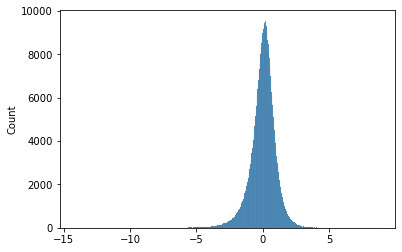

In [13]:
### We will plot the histogram of a randomly selected feature of the latents
seed = 0
np.random.seed(seed)
index_rand = np.random.randint(512)
sns.histplot(latents[:, index_rand])

### From above histograms, we know that all the features of the latents almost belong to the standard normal distribution.

## Let's do linear transformation to standarize the latent vector at first.
### For each component, we do $x_{std} = (x - \mu) / \sigma(x)$.

In [14]:
### Initialize the linear transformer at first
scaler = StandardScaler()
### Estimate the parameters
scaler.fit(latents)
### Transform the latents
latents_std = scaler.transform(latents)

In [15]:
### Let's use PCA at first to estimate the dimension of the main components. But before that, we want to standarize the latent vector
pca = PCA(n_components='mle', random_state=0)
pca.fit(latents_std)
singular_vals = pca.singular_values_

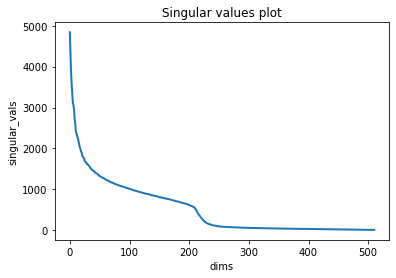

In [16]:
### plot the singular values to estimate the dimensions
plt.figure()
plt.title('Singular values plot')
plt.plot(singular_vals.squeeze(), linewidth=2)
plt.xlabel('dims')
plt.ylabel('singular_vals')
plt.show()

### From above plot, actually we can try to use the $dims = 300$ for the latent space.
### Here we use $dims = 256$.

In [17]:
pca = PCA(n_components=256, random_state=0)
pca.fit(latents_std)
latents_reduced = pca.transform(latents_std)
print(latents_reduced.shape)

(751689, 256)


## In the block, we will take the LL of each Latent vector. (We thank Prof. X's nice codes for matching.)

In [41]:
### At first let's get the index list of the latent vectors. Here we thank Prof. X for his nice 'matching' codes.
y2019 = evals_tbl.pp_file == 's3://modis-l2/PreProc/MODIS_R2019_2019_95clear_128x128_preproc_std.h5'
### Check the total number of the number of latents
assert np.sum(y2019) == latents.shape[0], 'The index list is not consistent with the latents vector!'
print(f'The total number of latents is: {np.sum(y2019)}.')
### Get the index list of the latent vector
idx = evals_tbl[y2019].pp_idx.values

The total number of latents is: 751689.


### Naively, we just split the latents vectors into two groups according to the LL.

In [43]:
### At first, let's check the statistics of the LL
evals_tbl[y2019].LL.describe()

count    751689.000000
mean        228.834571
std         234.529433
min       -5957.205078
25%          95.118042
50%         243.577942
75%         382.215637
max        1007.517334
Name: LL, dtype: float64

<AxesSubplot:xlabel='LL', ylabel='Count'>

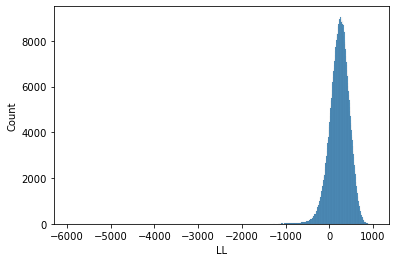

In [44]:
sns.histplot(evals_tbl[y2019].LL)

### Obviously, we can find that the latent vector has heavy left hand tail which means outliers exist. So we will naively choose 
* ll_threshold= -2000


In [84]:
### Get the value (np.array) of the LL series
LL_latents_np = evals_tbl[y2019].LL.values.copy()

In [85]:
### Split the index of the latents into two groups according to the threshold
ll_threshold = -2000
latents_cluster_1 = np.argwhere(LL_latents_np <= ll_threshold).squeeze()
latents_cluster_2 = np.argwhere(LL_latents_np > ll_threshold).squeeze()
print(f'The number of samples in the first cluster is: {len(latents_cluster_1)}.')
print(f'The number of samples in the second cluster is: {len(latents_cluster_2)}.')

The number of samples in the first cluster is: 200.
The number of samples in the second cluster is: 751489.


## We will use the UMap to explore the latents. 

#### Initialize the umap reducer.

In [28]:
%%time
reducer_umap = umap.UMAP()
latents_embedding = reducer_umap.fit_transform(latents_reduced)
print('The shape of the reduced matrix is: ', latents_embedding.shape)
print('The dimension of the embedding manifold is: ', latents_embedding.shape[1])

The shape of the reduced matrix is:  (751689, 2)
The dimension of the embedding manifold is:  2
CPU times: user 10h 45min 32s, sys: 1h 36min 38s, total: 12h 22min 10s
Wall time: 14min 34s


Text(0.5, 1.0, 'Scatter plot of embedding manifold by UMAP')

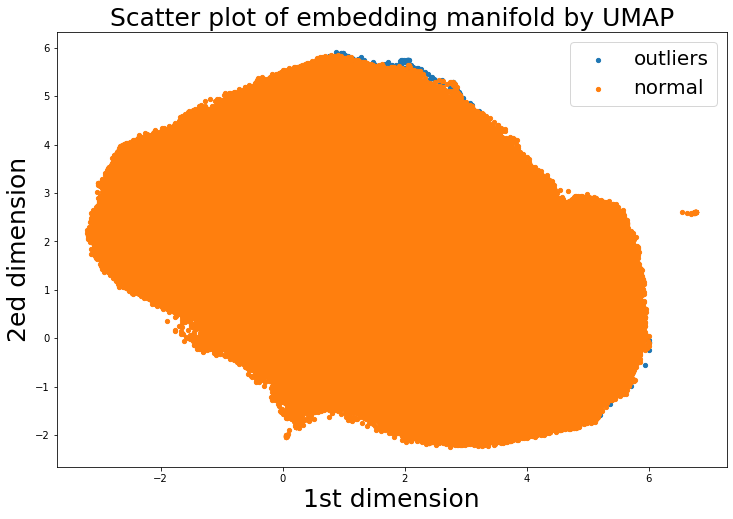

In [86]:
plt.figure(figsize=(12, 8))
plt.scatter(latents_embedding[:, 0][latents_cluster_1], latents_embedding[:, 1][latents_cluster_1],
            s=18, label='outliers')
plt.scatter(latents_embedding[:, 0][latents_cluster_2], latents_embedding[:, 1][latents_cluster_2],
            s=18, label='normal')
plt.xlabel('1st dimension', fontsize=25)
plt.ylabel('2ed dimension', fontsize=25)
plt.legend(fontsize=20, loc=1)
plt.title('Scatter plot of embedding manifold by UMAP', fontsize=25)

## Try Another Threshold value
* ll_threshold = -1000

In [87]:
### Split the index of the latents into two groups according to the threshold
ll_threshold = -1000
latents_cluster_1 = np.argwhere(LL_latents_np <= ll_threshold).squeeze()
latents_cluster_2 = np.argwhere(LL_latents_np > ll_threshold).squeeze()
print(f'The number of samples in the first cluster is: {len(latents_cluster_1)}.')
print(f'The number of samples in the second cluster is: {len(latents_cluster_2)}.')

The number of samples in the first cluster is: 1137.
The number of samples in the second cluster is: 750552.


Text(0.5, 1.0, 'Scatter plot of embedding manifold by UMAP')

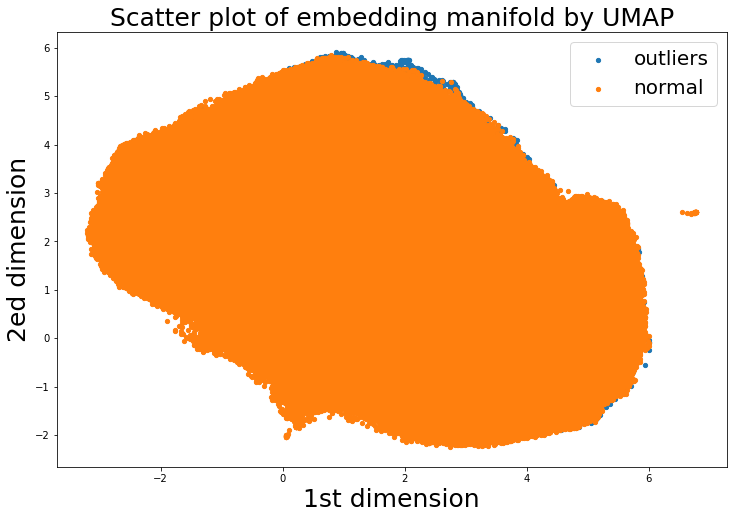

In [88]:
plt.figure(figsize=(12, 8))
plt.scatter(latents_embedding[:, 0][latents_cluster_1], latents_embedding[:, 1][latents_cluster_1],
            s=18, label='outliers')
plt.scatter(latents_embedding[:, 0][latents_cluster_2], latents_embedding[:, 1][latents_cluster_2],
            s=18, label='normal')
plt.xlabel('1st dimension', fontsize=25)
plt.ylabel('2ed dimension', fontsize=25)
plt.legend(fontsize=20, loc=1)
plt.title('Scatter plot of embedding manifold by UMAP', fontsize=25)

## Try Another Threshold value
* ll_threshold = -500

In [89]:
### Split the index of the latents into two groups according to the threshold
ll_threshold = -500
latents_cluster_1 = np.argwhere(LL_latents_np <= ll_threshold).squeeze()
latents_cluster_2 = np.argwhere(LL_latents_np > ll_threshold).squeeze()
print(f'The number of samples in the first cluster is: {len(latents_cluster_1)}.')
print(f'The number of samples in the second cluster is: {len(latents_cluster_2)}.')

The number of samples in the first cluster is: 4788.
The number of samples in the second cluster is: 746901.


Text(0.5, 1.0, 'Scatter plot of embedding manifold by UMAP')

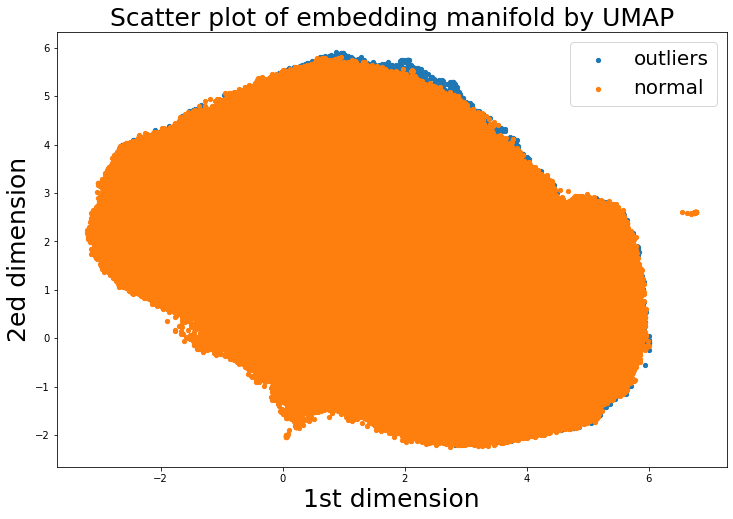

In [90]:
plt.figure(figsize=(12, 8))
plt.scatter(latents_embedding[:, 0][latents_cluster_1], latents_embedding[:, 1][latents_cluster_1],
            s=18, label='outliers')
plt.scatter(latents_embedding[:, 0][latents_cluster_2], latents_embedding[:, 1][latents_cluster_2],
            s=18, label='normal')
plt.xlabel('1st dimension', fontsize=25)
plt.ylabel('2ed dimension', fontsize=25)
plt.legend(fontsize=20, loc=1)
plt.title('Scatter plot of embedding manifold by UMAP', fontsize=25)